# End-to-End Project on Time Series Analysis and Forecasting 


### Loading Code To Pull Data From Google Cloud Platform

In [ ]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import  drive
drive.mount('/drive')
import pandas as pd

#drive.mount("/drive", force_remount=True)

Mounted at /drive


In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user('jbpatty01@gmail.com')
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## 2013-2018 Divvy Dataset + Data Preprocessing




In [ ]:
link = 'https://drive.google.com/file/d/1x4x0KmjuOVbO_cg6WM58pTOedCsERWvP/view?usp=sharing' # The shareable link

fluff, id = link.split('d/')
id = id[0:33]
print (id) # Verify that you have everything after 'd/'

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
rides = pd.read_csv('Filename.csv')
# Dataset is now stored in a Pandas Dataframe

1x4x0KmjuOVbO_cg6WM58pTOedCsERWvP


In [ ]:
# 17,425,340 Divvy rides
len(rides)

17425340

In [ ]:
# Dropping unnecessary columns for time-series analyis 

cols = ['trip_id', 'end_time', 'bikeid',
       'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'usertype']
  
rides.drop(cols, axis=1, inplace=True)

In [ ]:
# Setting column name for time to match column name in traffic congestion dataset 
rides = rides.rename(columns={'start_time':'time'})

In [ ]:
# Setting date/time and stripping hours, minutes, and seconds
rides['time'] = pd.to_datetime(rides['time'])
rides['time'] = rides['time'].dt.date
rides['time'] = pd.to_datetime(rides['time'])

In [ ]:
# Checking min and max dates of dataset
rides['time'].min(), rides['time'].max()

(Timestamp('2013-06-27 00:00:00'), Timestamp('2018-12-31 00:00:00'))

In [ ]:
# Match min and max dates of traffic congestion dataset - 14,446,499 Divvy rides
after_start_date = rides["time"] >= '2013-06-27 00:00:00'
before_end_date = rides["time"] <= '2018-05-03 00:00:00'
between_two_dates = after_start_date & before_end_date
rides = rides.loc[between_two_dates]
print(len(rides))

14446499


In [ ]:
# Sorting time and checking for missing values
rides = rides.sort_values('time')
rides.isnull().sum()

time            0
tripduration    0
dtype: int64

In [ ]:
# Convert trip duraton from seconds to hours to match traffic speed in MPH 
rides['tripduration'] = rides['tripduration']/3600

In [ ]:
# Aggregate trip duration by date
rides = rides.groupby('time')['tripduration'].sum().reset_index()

In [ ]:
rides.sample(5)

,time,tripduration
983,2016-03-08,2550.878889
1159,2016-08-31,3798.872778
470,2014-10-12,3214.394167
931,2016-01-16,417.058889
633,2015-03-24,361.134444


## Time Series Analysis 

In [ ]:
# Code for ARIMA an Prophet
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

### Indexing with Time Series Data

In [ ]:
# Set dataframe index
rides = rides.set_index('time')
rides.index

DatetimeIndex(['2013-06-27', '2013-06-28', '2013-06-29', '2013-06-30',
               '2013-07-01', '2013-07-02', '2013-07-03', '2013-07-04',
               '2013-07-05', '2013-07-06',
               ...
               '2018-04-24', '2018-04-25', '2018-04-26', '2018-04-27',
               '2018-04-28', '2018-04-29', '2018-04-30', '2018-05-01',
               '2018-05-02', '2018-05-03'],
              dtype='datetime64[ns]', name='time', length=1770, freq=None)

In [ ]:
# Frequency conversion and resampling for time series
y_rides = rides['tripduration'].resample('MS').mean()

In [ ]:
# Sample of 2017  
y_rides['2017':]

time
2017-01-01     674.718853
2017-02-01    1348.672073
2017-03-01     979.804543
2017-04-01    2446.181556
2017-05-01    3059.387133
2017-06-01    4924.664111
2017-07-01    5642.786971
2017-08-01    5126.019041
2017-09-01    4422.544398
2017-10-01    2751.470116
2017-11-01    1214.056102
2017-12-01     747.758566
2018-01-01    1084.467231
2018-02-01     985.442202
2018-03-01    1619.526720
2018-04-01    2262.972065
2018-05-01    4140.173426
Freq: MS, Name: tripduration, dtype: float64

### Visualizing Traffic Speed Time Series Data

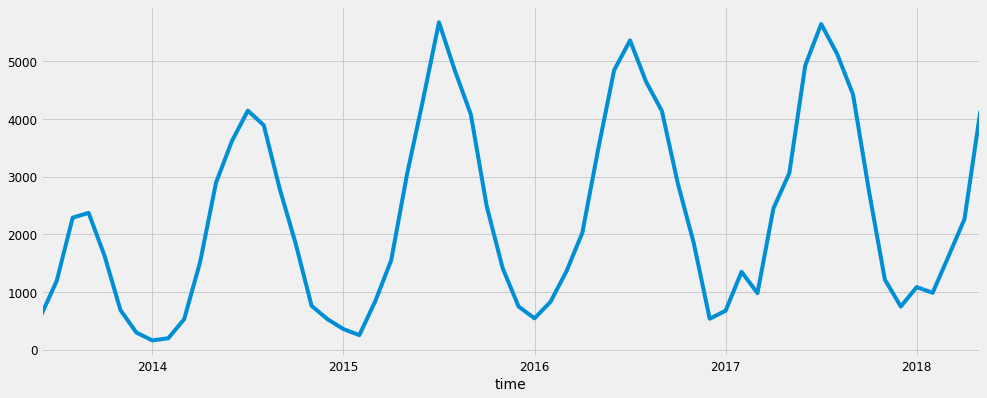

In [ ]:
# Time Series Plot

y_rides.plot(figsize=(15, 6))
plt.show()

Time-series has a seasonality pattern where rides are always low at the beginning and end of a year and high in the middle of the year. This makes sense considering the cold and windy winters in Chicago.

However, year-over-year, there is an upward trend at the trough of the low months.



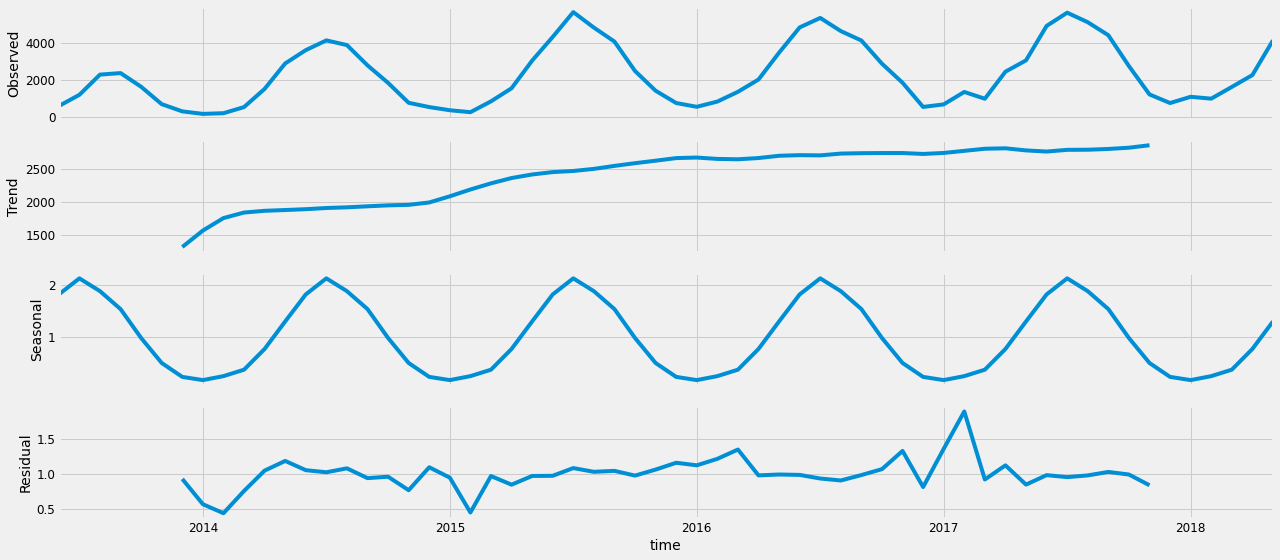

In [ ]:
# Decomposition Plot

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y_rides, model='multiplicative')
fig = decomposition.plot()
plt.show()

Decomposition Plot shows very clearly that the data has an overall upward trend, seasonal fluctuations, and fairly random residuals. 

The missing values in both the trend and residual lines happens because decomposition uses a moving average to base its estimate.

## Time series forecasting with ARIMA

In [ ]:
# Parameters p, d, q account for seasonality, trend, and noise in the data

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
# This step is parameter Selection for our bike share’s trip duration ARIMA Time Series Model 
# Goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

### Fitting the ARIMA model

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y_rides,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0795      0.285     -0.279      0.780      -0.638       0.479
ma.L1         -0.7033      0.251     -2.799      0.005      -1.196      -0.211
ar.S.L12      -0.1574      0.106     -1.492      0.136      -0.364       0.049
sigma2       1.68e+05   5.25e+04      3.199      0.001    6.51e+04    2.71e+05


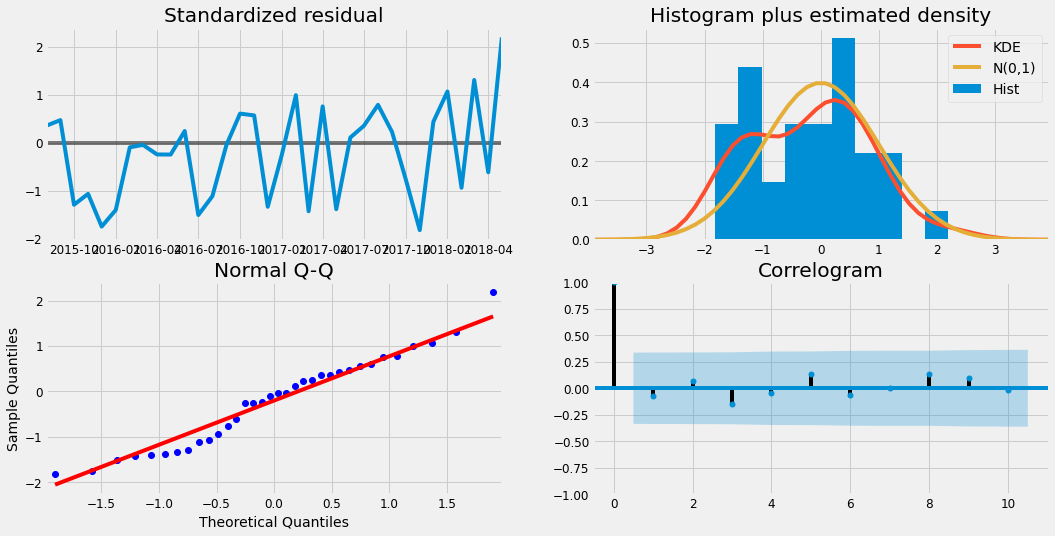

In [ ]:
# Run model diagnostics to investigate any unusual behavior

results.plot_diagnostics(figsize=(16, 8))
plt.show()

### Validating forecasts

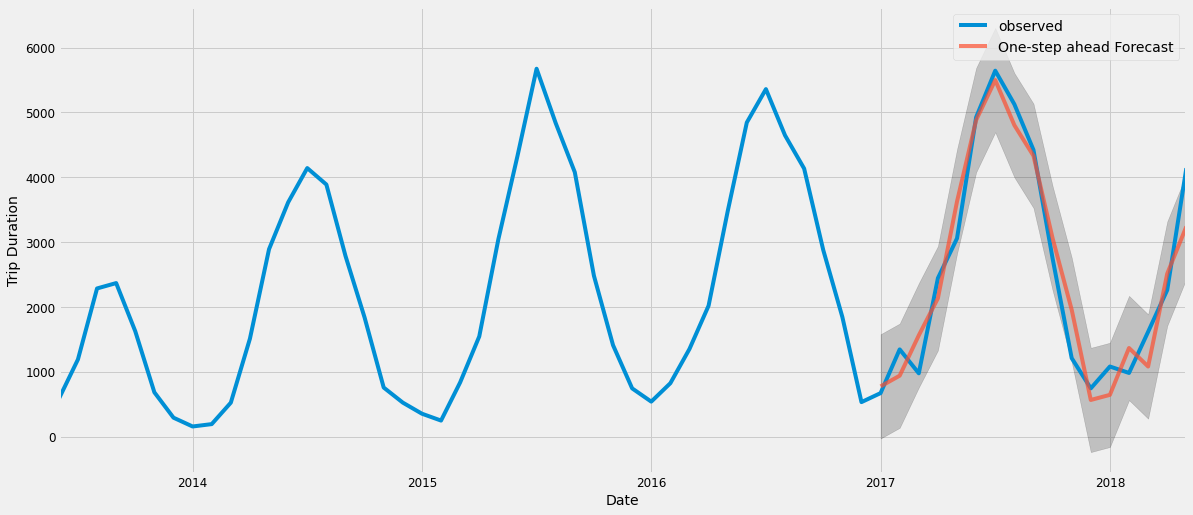

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y_rides['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(18, 8))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Trip Duration')

plt.legend()
plt.show()

Plot is observed values compared to the rolling forecasted predictions.

Forecasts set to start on 2017-01-01 until end of the data on 2018-05-03. 

Forecasts align with the true values really well, showing an upward trend starting from the beginning of the year and capturing the seasonality in the in second half of the year.

In [ ]:
# Mean Squared Error

y_forecasted = pred.predicted_mean
y_truth = y_rides['2017-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 191311.86


In [ ]:
# Root Mean Squared Error

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 437.39


In [ ]:
# Mean Abolute Error
 
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_truth, y_forecasted)
print('The Mean Absolute Error of the forecasts: %f' % mae)

The Mean Absolute Error of the forecasts: 371.587270


In [ ]:
# Mean Abolute Percentage Error

mape = np.mean(np.abs((y_truth - y_forecasted)/ y_truth)) * 100
print('The Mean Absolute Percentage Error of the forecasts: %f' % mape+'%')

The Mean Absolute Percentage Error of the forecasts: 22.940271%


MAPE indicates the average difference between the predicted trip duration and the actual trip duration is 22.94%

### Producing and visualizing forecasts

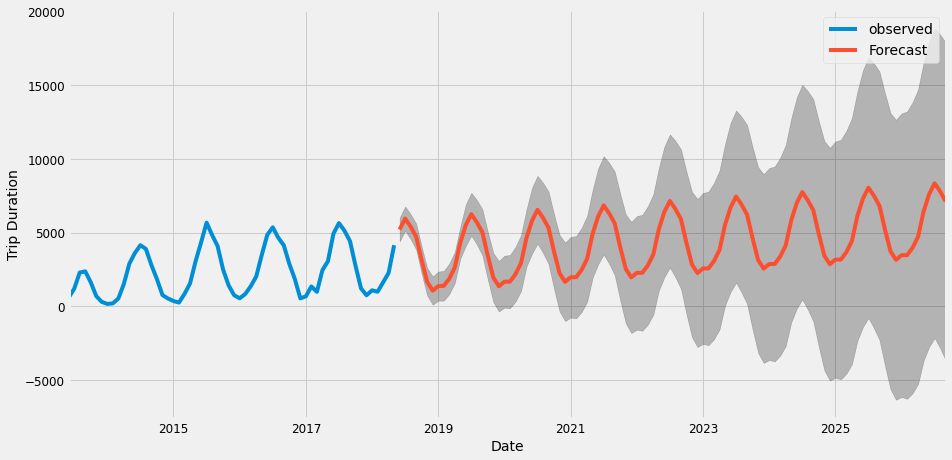

In [ ]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y_rides.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Trip Duration')

plt.legend()
plt.show()

ARIMA captured bike share seasonality. 

As the forecast moves further out into the future, it’s natural for it to become less confident in its values which is reflected by the confidence intervals growing larger.



## Time Series of Traffic Congestion vs. Divvy Bike Rides

### Chicago Traffic Congestion Dataset + Data Preprocessing

In [ ]:
link2 = 'https://drive.google.com/file/d/1z4R0C5ggLHjB03pVaUmIq5Zgc1SpptCE/view?usp=sharing' # The shareable link

fluff2, id2 = link2.split('d/')
id2 = id2[0:33]
print (id2) # Verify that you have everything after 'd/'

downloaded2 = drive.CreateFile({'id':id2}) 
downloaded2.GetContentFile('Filename.csv')  
traffic = pd.read_csv('Filename.csv')
# Dataset is now stored in a Pandas Dataframe

1z4R0C5ggLHjB03pVaUmIq5Zgc1SpptCE


In [ ]:
# Dropping unnecessary columns for time-series analyis 

cols = ['REGION_ID', 'BUS COUNT',
       'NUMBER OF READS                      ']

traffic.drop(cols, axis=1, inplace=True)

In [ ]:
# Setting column name for lowercase time to match column name in bike share dataset 

traffic = traffic.rename(columns={'TIME':'time', 'SPEED':'speed'})

In [ ]:
# Setting date/time and stripping hours, minutes, and seconds

traffic['time'] = pd.to_datetime(traffic['time'])
traffic['time'] = traffic['time'].dt.date
traffic['time'] = pd.to_datetime(traffic['time'])

In [ ]:
# Min and max of dataset 

traffic['time'].min(), traffic['time'].max()

(Timestamp('2013-01-18 00:00:00'), Timestamp('2018-05-03 00:00:00'))

In [ ]:
# Match min and max dates of bike share dataset - 6,432,316 traffic records
after_start_date = traffic["time"] >= '2013-06-27 00:00:00'
before_end_date = traffic["time"] <= '2018-05-03 00:00:00'
between_two_dates = after_start_date & before_end_date
traffic = traffic.loc[between_two_dates]
print(len(traffic))

6432316


In [ ]:
# Sorting time and checking for missing values

traffic = traffic.sort_values('time')
traffic.isnull().sum()

time     0
speed    0
dtype: int64

In [ ]:
# Aggregate traffic speed by date

traffic = traffic.groupby('time')['speed'].mean().reset_index()

### Data Exploration

In [ ]:
# Set dataframe index

traffic = traffic.set_index('time')

In [ ]:
# Frequency conversion and resampling for time series

y_traffic = traffic['speed'].resample('MS').mean()

In [ ]:
# Sample of 2017  

y_traffic['2017':]

time
2017-01-01    21.966294
2017-02-01    22.057561
2017-03-01    21.548853
2017-04-01    21.879716
2017-05-01    22.240339
2017-06-01    22.321361
2017-07-01    22.389967
2017-08-01    22.350683
2017-09-01    22.295132
2017-10-01    21.965131
2017-11-01    22.086680
2017-12-01    21.973969
2018-01-01    21.741684
2018-02-01    21.488837
2018-03-01    21.842439
2018-04-01    21.910901
2018-05-01    21.417475
Freq: MS, Name: speed, dtype: float64

## ARIMA Time Series Analysis - Divvy Bike Share vs Chicago Traffic Congestion 

In [ ]:
# Arrange data in a standard normal distribution.

from sklearn.preprocessing import StandardScaler

scaler_r = StandardScaler()
rides_scaled = scaler_r.fit_transform(rides['tripduration'].values.reshape(-1,1))

scaler_t = StandardScaler()
traffic_scaled = scaler_t.fit_transform(traffic['speed'].values.reshape(-1,1))

In [ ]:
# Add scaled features to dataset

rides['rides_scaled'] = rides_scaled
traffic['traffic_scaled'] = traffic_scaled

In [ ]:
# Min and max of scaled feature - trip duration

rides['rides_scaled'].min(), rides['rides_scaled'].max()

(-1.1789355366107808, 5.037677787281312)

In [ ]:
# Min and max of scaled feature - traffic speed

traffic['traffic_scaled'].min(), traffic['traffic_scaled'].max()

(-17.87586813670301, 7.152919994364238)

In [ ]:
# Shape of datasets

traffic.shape, rides.shape

((1524, 2), (1770, 2))

In [ ]:
# Combine two data frames into one and plot these two categories’ time series into one plot

rides = pd.DataFrame({'time': rides.index, 'rides_scaled': rides.rides_scaled.values})                  
traffic = pd.DataFrame({'time':traffic.index, 'traffic_scaled':traffic.traffic_scaled.values})

transpo = traffic.merge(rides, how='inner', on='time')
transpo.rename(columns={'traffic_scaled': 'traffic_speed', 'rides_scaled': 'ride_duration'}, inplace=True)

transpo.head()

,time,traffic_speed,ride_duration
0,2013-06-27,0.375206,-1.126328
1,2013-06-28,0.325488,-0.927091
2,2013-06-29,1.613040,-0.858134
3,2013-06-30,1.735459,-0.603421
4,2013-07-01,0.421787,-0.791312


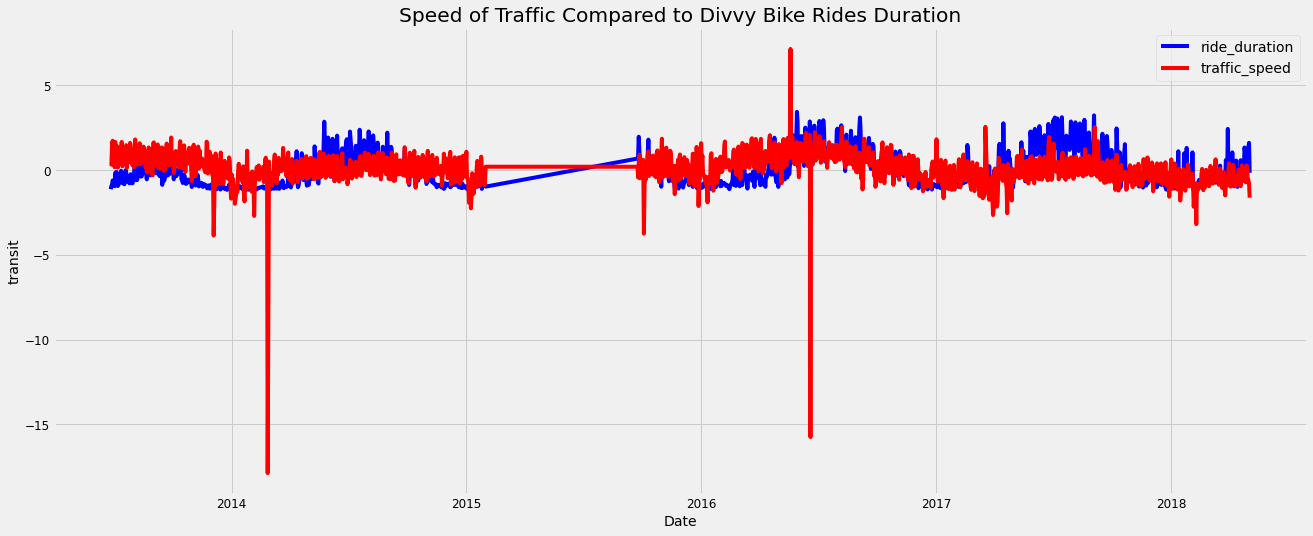

In [ ]:
plt.figure(figsize=(20, 8))

plt.plot(transpo['time'], transpo['ride_duration'], 'b-', label = 'ride_duration')
plt.plot(transpo['time'], transpo['traffic_speed'], 'r-', label = 'traffic_speed')

plt.xlabel('Date'); plt.ylabel('transit'); plt.title('Speed of Traffic Compared to Divvy Bike Rides Duration')
plt.legend();

## Time Series Modeling with Prophet

In [ ]:
traffic

,time,traffic_scaled
0,2013-06-27,0.375206
1,2013-06-28,0.325488
2,2013-06-29,1.613040
3,2013-06-30,1.735459
4,2013-07-01,0.421787
...,...,...
1519,2018-04-29,0.206736
1520,2018-04-30,-0.576507
1521,2018-05-01,-0.578461
1522,2018-05-02,-0.779664


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

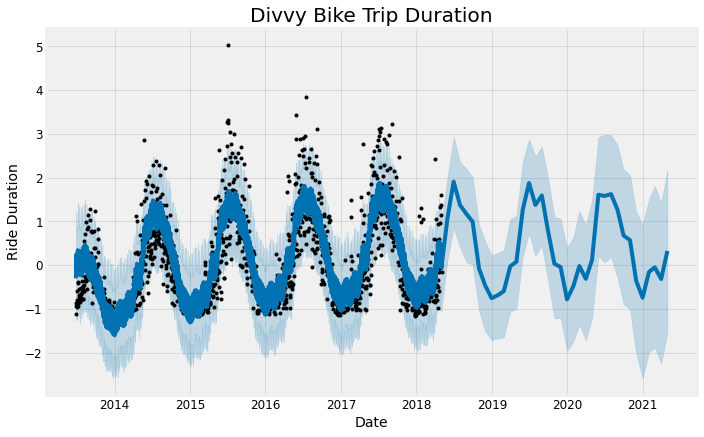

In [ ]:
from fbprophet import Prophet

rides = rides.rename(columns={'time': 'ds', 'rides_scaled': 'y'})
rides_model = Prophet(interval_width=0.95)
rides_model.fit(rides)

traffic = traffic.rename(columns={'time': 'ds', 'traffic_scaled': 'y'})
traffic_model = Prophet(interval_width=0.95)
traffic_model.fit(traffic)

rides_forecast = rides_model.make_future_dataframe(periods=36, freq='M')
rides_forecast = rides_model.predict(rides_forecast)

traffic_forecast = traffic_model.make_future_dataframe(periods=36, freq='M')
traffic_forecast = traffic_model.predict(traffic_forecast)

plt.figure(figsize=(18, 6))

rides_model.plot(rides_forecast, xlabel = 'Date', ylabel = 'Ride Duration')

plt.title('Divvy Bike Trip Duration');

<Figure size 1296x432 with 0 Axes>

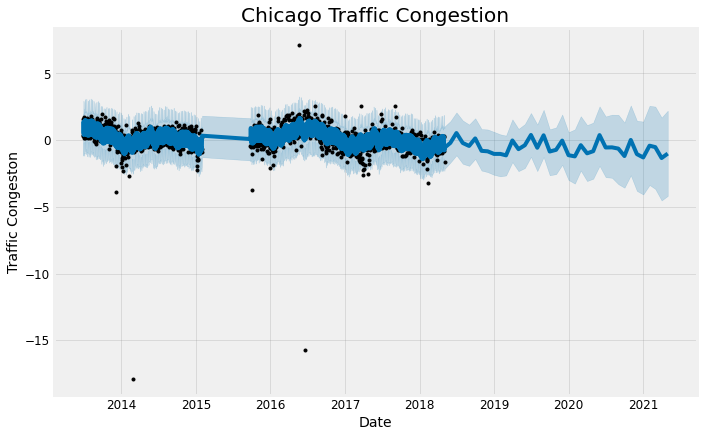

In [ ]:
plt.figure(figsize=(18, 6))
traffic_model.plot(traffic_forecast, xlabel = 'Date', ylabel = 'Traffic Congeston')
plt.title('Chicago Traffic Congestion');

### Compare Forecasts

In [ ]:
rides_names = ['rides_%s' % column for column in rides_forecast.columns]
traffic_names = ['traffic_%s' % column for column in traffic_forecast.columns]

merge_rides_forecast = rides_forecast.copy()
merge_traffic_forecast = traffic_forecast.copy()

merge_rides_forecast.columns = rides_names
merge_traffic_forecast.columns = traffic_names

forecast = pd.merge(merge_rides_forecast, merge_traffic_forecast, how = 'inner', left_on = 'rides_ds', right_on = 'traffic_ds')

forecast = forecast.rename(columns={'rides_ds': 'Date'}).drop('traffic_ds', axis=1)

forecast.head()

,Date,rides_trend,rides_yhat_lower,rides_yhat_upper,rides_trend_lower,rides_trend_upper,rides_additive_terms,rides_additive_terms_lower,rides_additive_terms_upper,rides_weekly,rides_weekly_lower,rides_weekly_upper,rides_yearly,rides_yearly_lower,rides_yearly_upper,rides_multiplicative_terms,rides_multiplicative_terms_lower,rides_multiplicative_terms_upper,rides_yhat,traffic_trend,traffic_yhat_lower,traffic_yhat_upper,traffic_trend_lower,traffic_trend_upper,traffic_additive_terms,traffic_additive_terms_lower,traffic_additive_terms_upper,traffic_weekly,traffic_weekly_lower,traffic_weekly_upper,traffic_yearly,traffic_yearly_lower,traffic_yearly_upper,traffic_multiplicative_terms,traffic_multiplicative_terms_lower,traffic_multiplicative_terms_upper,traffic_yhat
0,2013-06-27,-1.332958,-1.259723,0.620994,-1.332958,-1.332958,1.029478,1.029478,1.029478,-0.164476,-0.164476,-0.164476,1.193954,1.193954,1.193954,0.0,0.0,0.0,-0.303480,0.464191,-1.161103,1.959364,0.464191,0.464191,-0.019285,-0.019285,-0.019285,-0.214560,-0.214560,-0.214560,0.195275,0.195275,0.195275,0.0,0.0,0.0,0.444906
1,2013-06-28,-1.327005,-1.127682,0.874456,-1.327005,-1.327005,1.190135,1.190135,1.190135,-0.023198,-0.023198,-0.023198,1.213333,1.213333,1.213333,0.0,0.0,0.0,-0.136870,0.462063,-1.036302,1.861169,0.462063,0.462063,-0.038941,-0.038941,-0.038941,-0.268458,-0.268458,-0.268458,0.229518,0.229518,0.229518,0.0,0.0,0.0,0.423122
2,2013-06-29,-1.321053,-0.710513,1.216640,-1.321053,-1.321053,1.562339,1.562339,1.562339,0.331272,0.331272,0.331272,1.231067,1.231067,1.231067,0.0,0.0,0.0,0.241287,0.459935,-0.237770,2.949953,0.459935,0.459935,0.919440,0.919440,0.919440,0.657309,0.657309,0.657309,0.262132,0.262132,0.262132,0.0,0.0,0.0,1.379375
3,2013-06-30,-1.315100,-0.793851,1.095672,-1.315100,-1.315100,1.484138,1.484138,1.484138,0.237300,0.237300,0.237300,1.246838,1.246838,1.246838,0.0,0.0,0.0,0.169038,0.457807,-0.145499,2.834874,0.457807,0.457807,0.937593,0.937593,0.937593,0.645068,0.645068,0.645068,0.292525,0.292525,0.292525,0.0,0.0,0.0,1.395400
4,2013-07-01,-1.309147,-1.095574,0.907352,-1.309147,-1.309147,1.216272,1.216272,1.216272,-0.044105,-0.044105,-0.044105,1.260376,1.260376,1.260376,0.0,0.0,0.0,-0.092876,0.455679,-1.026516,2.017185,0.455679,0.455679,0.105118,0.105118,0.105118,-0.215069,-0.215069,-0.215069,0.320187,0.320187,0.320187,0.0,0.0,0.0,0.560797


### Trend and Forecast Visualization

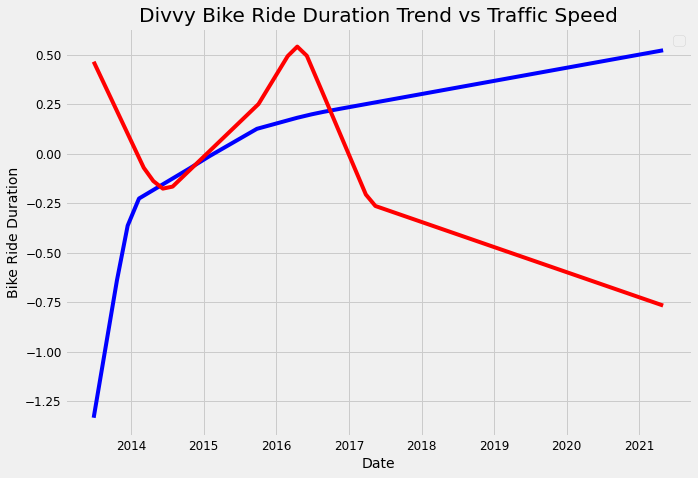

In [ ]:
plt.figure(figsize=(10, 7))

plt.plot(forecast['Date'], forecast['rides_trend'], 'b-')
plt.plot(forecast['Date'], forecast['traffic_trend'], 'r-')

plt.legend(); plt.xlabel('Date'); plt.ylabel('Bike Ride Duration')

plt.title('Divvy Bike Ride Duration Trend vs Traffic Speed');

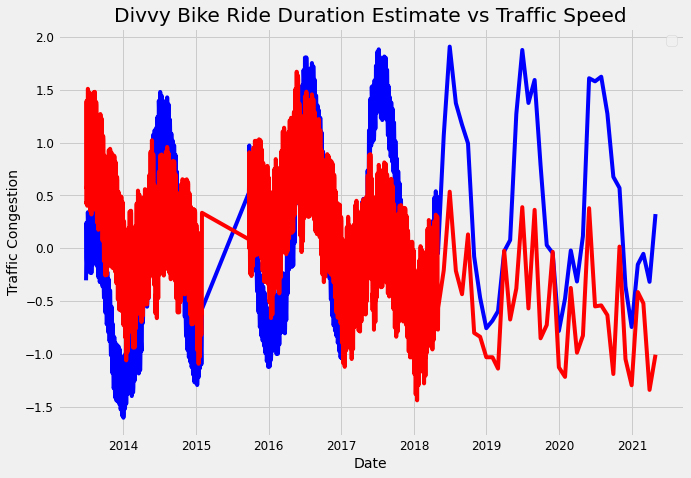

In [ ]:
plt.figure(figsize=(10, 7))

plt.plot(forecast['Date'], forecast['rides_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['traffic_yhat'], 'r-')

plt.legend(); plt.xlabel('Date'); plt.ylabel('Traffic Congestion')

plt.title('Divvy Bike Ride Duration Estimate vs Traffic Speed');

### Trends and Patterns

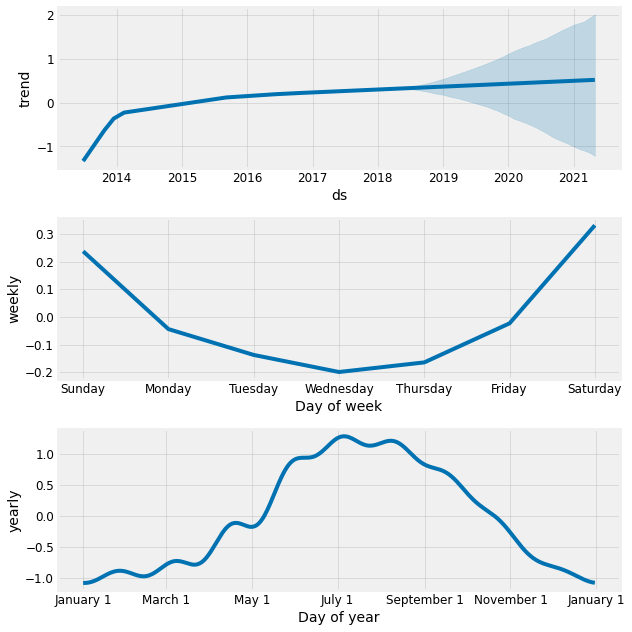

In [ ]:
rides_model.plot_components(rides_forecast);

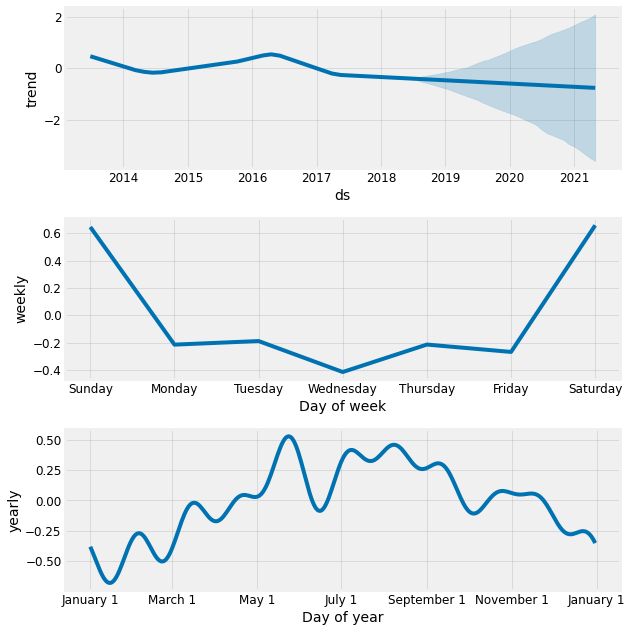

In [ ]:
traffic_model.plot_components(traffic_forecast);